# Import packages

In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import models
from torchsummary import summary
import json
from tqdm import tqdm

### 1. Data Preparation

#### 1.1 Load Dataset and Format for Split

In [2]:
# Load dataset from file and format data into a list
with open("diabetes_preprocessed.txt") as diabetes_file:
    rows = diabetes_file.readlines()
row_num = len(rows) # number of observations
col_num = 9         # number of columns
diabetes_array = np.full((row_num, col_num), np.nan)
for row_idx, row in enumerate(rows):
    observation = row.split()
    label = float(observation[0])
    diabetes_array[row_idx, 0] = label
    for feature in observation[1:]:
        feature_idx, feature_value = feature.split(":")
        diabetes_array[row_idx, int(feature_idx)] = float(feature_value)
diabetes_array[diabetes_array[:, 0] == 1, 0] = 0
diabetes_array[diabetes_array[:, 0] == -1, 0] = 1
diabetes_array = diabetes_array.astype(np.float32)

#### 1.2 Split dataset into training and testing

In [3]:
random_seed = 42
bigtrain_set, test_set = train_test_split(diabetes_array, test_size=0.2, 
                                          random_state=random_seed, stratify=diabetes_array[:, 0])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.25, 
                                          random_state=random_seed, stratify=bigtrain_set[:, 0])

#### 1.3 Data Cleaning

In [4]:
# Handling missing values
preproc_pl = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))]
)

trainp_set = preproc_pl.fit_transform(train_set)
valp_set = preproc_pl.fit_transform(val_set)
testp_set = preproc_pl.fit_transform(test_set)
bigtrainp_set = preproc_pl.fit_transform(bigtrain_set)

# Print dataset details
print('Bigtraining Dataset:', bigtrainp_set.shape)
print('\tTraining Dataset:', trainp_set.shape)
print('\tValidating Dataset:', valp_set.shape)
print('Testing Dataset:', testp_set.shape)

Bigtraining Dataset: (614, 9)
	Training Dataset: (460, 9)
	Validating Dataset: (154, 9)
Testing Dataset: (154, 9)


#### 1.4 Data Overview

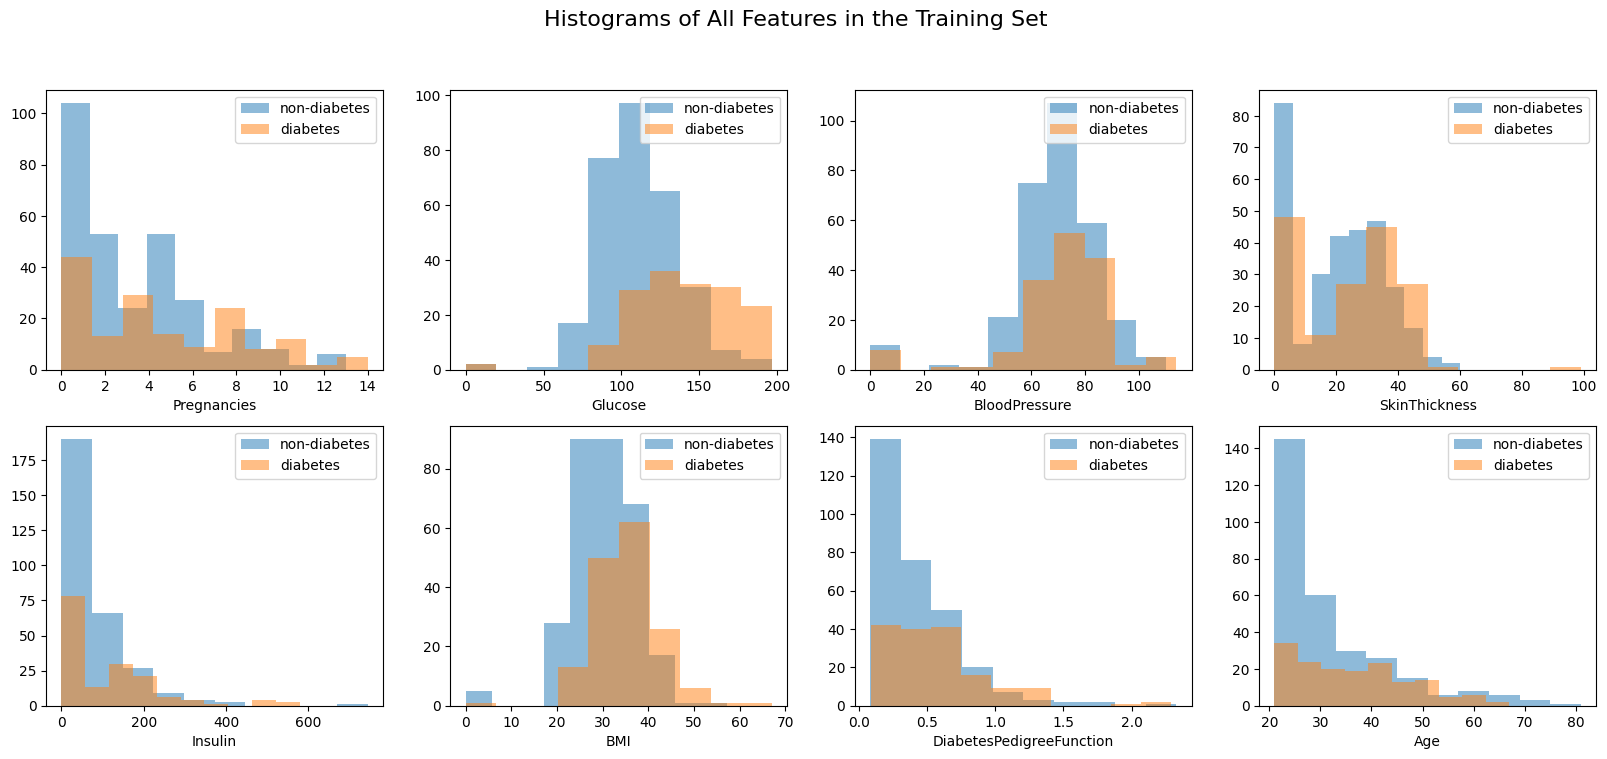

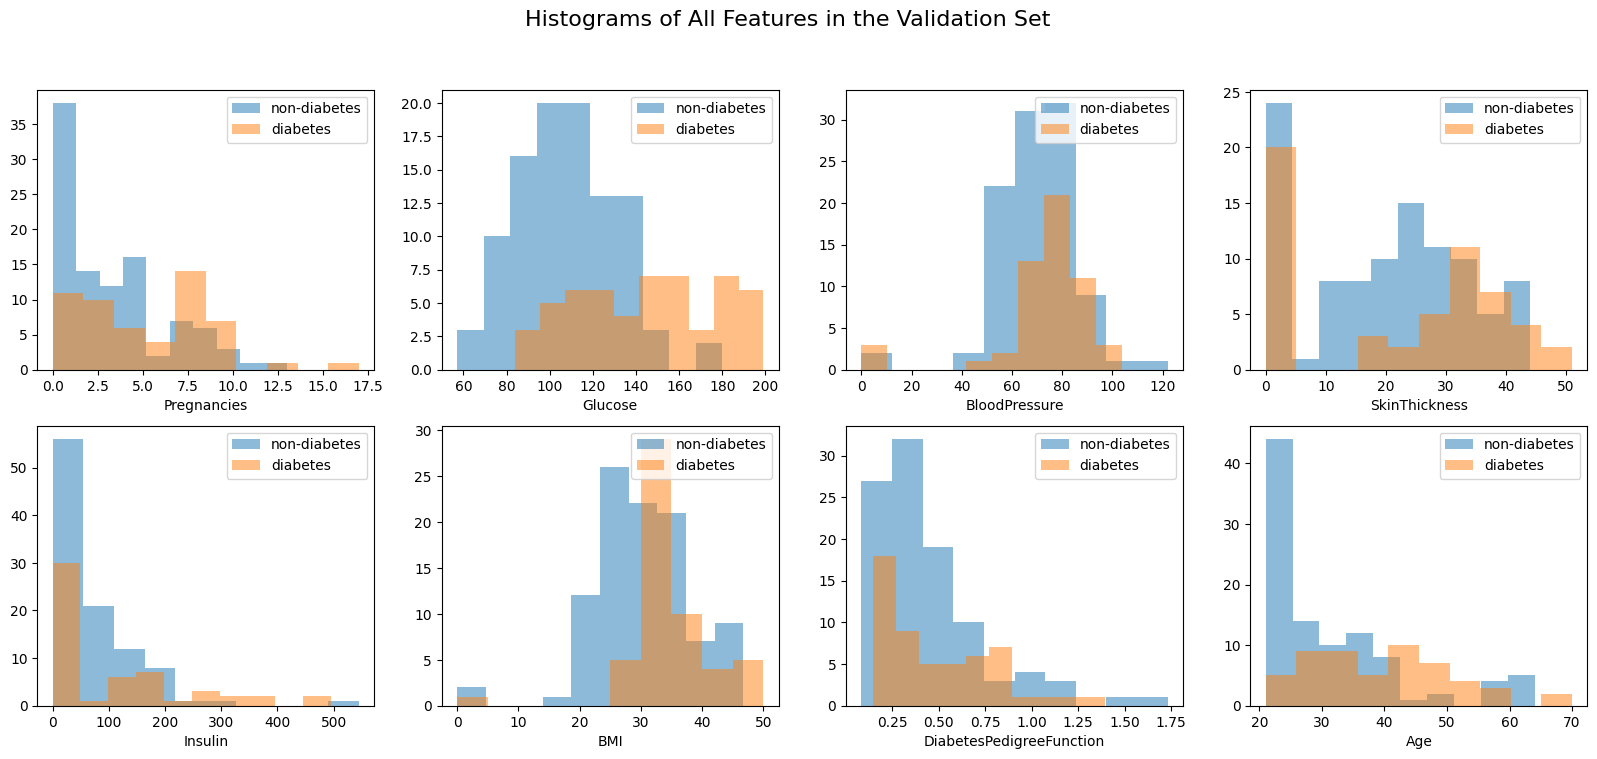

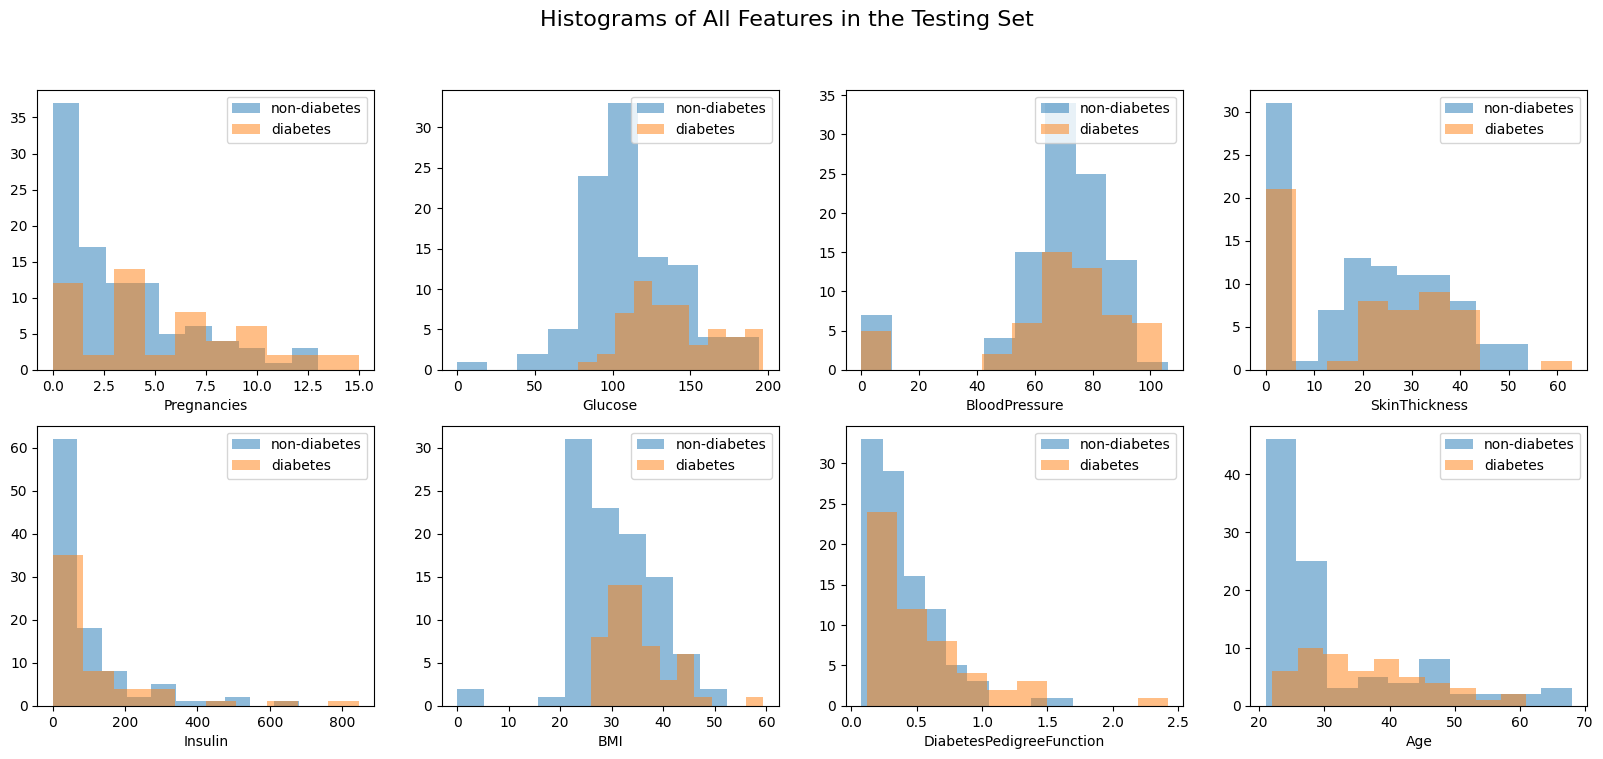

In [5]:
def draw_histogram(dataset, data_name, feature_names):
    wid = 4
    hei = int((dataset.shape[1] - 1) / wid)
    
    fig, axes = plt.subplots(hei, wid, 
                             figsize=(int(wid * 5), int(hei * 4)))
    
    fig.suptitle(f'Histograms of All Features in the {data_name} Set', fontsize=16)
    for h in range(hei):
        for w in range(wid):
            k = h * wid + w + 1
            if k >= dataset.shape[1]:
                break
            axes[h, w].hist(dataset[dataset[:, 0] == 0, k], alpha = 0.5, label = 'non-diabetes')
            axes[h, w].hist(dataset[dataset[:, 0] == 1, k], alpha = 0.5, label = 'diabetes')
            axes[h, w].set_xlabel(feature_names[k - 1])
            axes[h, w].legend(loc='upper right')
    pass

feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
draw_histogram(trainp_set, 'Training', feature_names)
draw_histogram(valp_set, 'Validation', feature_names)
draw_histogram(testp_set, 'Testing', feature_names)

#### 1.5 Create a Custom Dataset

In [6]:
class DiabeteDataset(Dataset):
    def __init__(self, data_array):
        self.diabetes_data = data_array
        
    def __len__(self):
        return len(self.diabetes_data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.diabetes_data[idx, 1:]), torch.tensor(self.diabetes_data[idx, 0])


diabetes_train = DiabeteDataset(trainp_set)
diabetes_val = DiabeteDataset(valp_set)
diabetes_test = DiabeteDataset(testp_set)
diabetes_bigtrain = DiabeteDataset(bigtrainp_set)

### 2. Training Models: Multi-scale Random Search

#### 2.1 Baseline

In [7]:
class MyScaleLayer(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return (input + 1.0) * 0.5


class DNNRunner():
    def __init__(self, train_dataset=None, val_dataset=None, hyper_params=None):
        if hyper_params is None:
            hyper_params = {}
        if 'model_version' not in hyper_params:
            hyper_params['model_version'] = 'single'
        if 'actfn' not in hyper_params:
            hyper_params['actfn'] = 'relu'
        if 'batch_size' not in hyper_params:
            hyper_params['batch_size'] = 16
        if 'learning_rate' not in hyper_params:
            hyper_params['learning_rate'] = 1.0
        if 'optimizer' not in hyper_params:
            hyper_params['optimizer'] = 'sgd'

        self.trial_tag = '_'.join(map(str, [
            hyper_params['model_version'],
            hyper_params['actfn'],
            hyper_params['batch_size'],
            hyper_params['learning_rate'],
            hyper_params['optimizer']
        ]))

        self.device = self.get_device()
        self.batch_size = int(hyper_params['batch_size'])
        self.learning_rate = hyper_params['learning_rate']
        self.actfn = self.get_actfn(hyper_params['actfn'])
        self.model_version = hyper_params['model_version']

        if train_dataset is not None:
            self.train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        if val_dataset is not None:
            self.val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        self.model = self.create_model().to(self.device)
        self.loss_fn = nn.BCELoss()  # nn.BCEWithLogitsLoss()
        self.optimizer = self.get_optimizer(hyper_params['optimizer'])(self.model.parameters(), lr=self.learning_rate)

    @staticmethod
    def get_device():
        device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )
        return device

    @staticmethod
    def get_optimizer(optimizer_name):
        if optimizer_name == 'sgd':
            return torch.optim.SGD
        elif optimizer_name == 'adam':
            return torch.optim.Adam
        elif optimizer_name == 'rmsprop':
            return torch.optim.RMSprop
        elif optimizer_name == 'nadam':
            return torch.optim.NAdam
        else:
            raise NotImplementedError(f'Unknown optimizer {optimizer_name}')
    
    @staticmethod
    def get_actfn(actfn):
        if actfn == 'relu':
            return nn.ReLU
        elif actfn == 'elu':
            return nn.ELU
        elif actfn == 'selu':
            return nn.SELU
        elif actfn == 'leaky_relu':
            return nn.LeakyReLU
        else:
            raise NotImplementedError(f'Unknown actfn {actfn}')

    @classmethod
    def report_model(cls, model_version):
        print(f'{model_version}:')
        single_model = cls(hyper_params={'model_version': model_version}).create_model()
        summary(single_model, (1, 8))

    def create_model(self):

        if self.model_version == 'single':
            model = nn.Sequential(
                nn.Linear(8, 1),
                nn.Tanh(),
                MyScaleLayer()
            )

        elif self.model_version == 'shallow':
            model = nn.Sequential(
                nn.Linear(8, 16),
                self.actfn(),
                nn.Linear(16, 16),
                self.actfn(),
                nn.Linear(16, 16),
                self.actfn(),
                nn.Linear(16, 16),
                self.actfn(),
                nn.Linear(16, 1),
                nn.Tanh(),
                MyScaleLayer()
            )
        elif self.model_version == 'deep':
            model = nn.Sequential(
                nn.Linear(8, 16),
                self.actfn(),
                nn.Linear(16, 16),
                self.actfn(),
                nn.Linear(16, 16),
                self.actfn(),
                nn.Linear(16, 32),
                self.actfn(),
                nn.Linear(32, 32),
                self.actfn(),
                nn.Linear(32, 16),
                self.actfn(),
                nn.Linear(16, 16),
                self.actfn(),
                nn.Linear(16, 16),
                self.actfn(),
                nn.Linear(16, 1),
                nn.Tanh(),
                MyScaleLayer()
            )
        else:
            raise NotImplementedError(f'Unknown model version {self.model_version}.')
        
        return model.to(self.device)
    
    def run(self, epoch):
        result = {
            'trial_tag': self.trial_tag,
            'epochs': epoch,
            'train_losses': [],
            'train_accs': [],
            'val_accs': [],
        }
        with tqdm(total=epoch) as pbar:
            for _ in range(epoch):
                pbar.update(1)
                self.model.train()
                train_loss, train_acc = self.train_one_epoch()
                result['train_losses'].append(train_loss)
                result['train_accs'].append(train_acc)

                self.model.eval()
                val_acc, all_y, all_y_pred = self.validate_one_epoch()
                result['val_accs'].append(val_acc)
                pbar.set_description(f'[t_loss]{train_loss:.2f};[v_acc]{val_acc:.2%}')
        
        # Evaluate the last
        metrics = self.compute_metrics(all_y, all_y_pred)
        return {**metrics, **result}

    def train_one_epoch(self):
        train_loss = 0.0
        train_acc = 0.0
        for X, y in self.train_dataloader:
            X, y = X.to(self.device), y.to(self.device)
            pred = self.model(X).reshape(-1)
            loss = self.loss_fn(pred, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            train_loss += loss.item()
            pred_y = (pred.detach().cpu() >= 0.5).int()
            train_acc += accuracy_score(pred_y, y.detach().cpu())
        train_loss /= len(self.train_dataloader)
        train_acc /= len(self.train_dataloader)
        return train_loss, train_acc
    
    def validate_one_epoch(self, test_dataset=None):
        test_dataloader = (
            DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
            if test_dataset is not None
            else self.val_dataloader
        )
        all_y, all_pred = [], []
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X).reshape(-1)
                all_y.append(y.detach().cpu())
                all_pred.append(pred.detach().cpu())
        all_y, all_pred = torch.cat(all_y), torch.cat(all_pred)
        all_y_pred = (all_pred >= 0.5).int()
        return accuracy_score(all_y, all_y_pred), all_y, all_y_pred
    
    def compute_metrics(self, all_y, all_y_pred):
        acc = accuracy_score(all_y, all_y_pred)
        cr = classification_report(all_y, all_y_pred,
                                   output_dict=True, zero_division=1)
        avg_results = cr.get('weighted avg', {})
        cm = confusion_matrix(all_y, all_y_pred)
        metrics = {
            'val_acc': acc,
            'precision': avg_results.get('precision', None),
            'recall': avg_results.get('recall', None),
            'f1_score': avg_results.get('f1-score', None),
            'confusion_matrix': json.dumps(cm.tolist(), default=lambda x: float(x)),
        }
        return metrics


In [9]:
DNNRunner.report_model('single')
DNNRunner.report_model('shallow')
DNNRunner.report_model('deep')

single:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 1]               9
              Tanh-2                 [-1, 1, 1]               0
      MyScaleLayer-3                 [-1, 1, 1]               0
Total params: 9
Trainable params: 9
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
shallow:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]             144
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 16]             272
              ReLU-4                

In [10]:
baseline_params = {
    'model_version': 'single',
    'actfn': 'relu',
    'batch_size': 16,
    'learning_rate': 1e-4,
    'optimizer': 'adam'    
}

dnn_baseline = DNNRunner(diabetes_bigtrain, diabetes_test, baseline_params)
baseline_res = dnn_baseline.run(200)

[t_loss]22.40;[v_acc]53.90%: 100%|██████████| 200/200 [00:17<00:00, 11.14it/s]


#### 2.2 Multi-scale random search for hyper parameters

We do 50 training runs in total to balance the search area and the effciency.

- 30 training runs in the first random searching
- 20 training runs in the second searching

In [11]:
def random_search(hyper_params, trial_num=30):

    all_res = []

    # Randomly select hyperparameters
    used_config = set()
    all_params = []
    for trial_idx in range(trial_num):
        dict_params = {}
        while True:
            config_record = []
            for key in hyper_params.keys():
                dict_params[key] = np.random.choice(hyper_params[key])
                config_record.append(dict_params[key])
            config_record = tuple(config_record)
            if config_record not in used_config:
                used_config.add(config_record)
                break
        all_params.append(dict_params)
    
    # Run trials
    for idx, params in enumerate(all_params):
        dnn_trial = DNNRunner(diabetes_train, diabetes_val, params)
        print(f'Trail {idx} ({dnn_trial.trial_tag}):')
        res = dnn_trial.run(200)
        # print(f'Trail {idx} completed.')
        all_res.append(res)

    return all_res

In [14]:
# First search
first_search_params = {
    'model_version': ['single', 'shallow', 'deep'],
    'actfn': ['relu', 'elu', 'selu', 'leaky_relu'],
    'batch_size': [8, 16, 32],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'optimizer': ['adam', 'rmsprop', 'nadam']
}  # 3 * 4 * 3 * 4 * 3 = 432

first_results = random_search(first_search_params)

Trail 0 (deep_elu_16_0.01_nadam):


[t_loss]0.42;[v_acc]75.32%: 100%|██████████| 200/200 [00:29<00:00,  6.80it/s]


Trail 1 (shallow_elu_8_0.0001_nadam):


[t_loss]0.46;[v_acc]79.22%: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


Trail 2 (single_selu_32_0.01_rmsprop):


[t_loss]34.38;[v_acc]64.94%: 100%|██████████| 200/200 [00:07<00:00, 25.46it/s]


Trail 3 (shallow_selu_8_0.001_adam):


[t_loss]0.32;[v_acc]74.68%: 100%|██████████| 200/200 [00:36<00:00,  5.46it/s]


Trail 4 (single_relu_16_0.0001_nadam):


[t_loss]65.05;[v_acc]35.06%: 100%|██████████| 200/200 [00:13<00:00, 14.96it/s]


Trail 5 (shallow_elu_16_0.0001_adam):


[t_loss]0.48;[v_acc]76.62%: 100%|██████████| 200/200 [00:19<00:00, 10.23it/s]


Trail 6 (deep_relu_8_0.01_adam):


[t_loss]0.65;[v_acc]64.94%: 100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


Trail 7 (deep_relu_16_0.001_nadam):


[t_loss]0.30;[v_acc]74.68%: 100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


Trail 8 (deep_selu_16_0.01_nadam):


[t_loss]0.65;[v_acc]64.94%: 100%|██████████| 200/200 [00:27<00:00,  7.34it/s]


Trail 9 (single_leaky_relu_32_0.0001_nadam):


[t_loss]23.21;[v_acc]63.64%: 100%|██████████| 200/200 [00:08<00:00, 23.76it/s]


Trail 10 (deep_leaky_relu_32_0.001_adam):


[t_loss]0.31;[v_acc]75.32%: 100%|██████████| 200/200 [00:14<00:00, 13.63it/s]


Trail 11 (shallow_selu_16_0.01_nadam):


[t_loss]0.42;[v_acc]74.68%: 100%|██████████| 200/200 [00:20<00:00,  9.71it/s]


Trail 12 (single_leaky_relu_32_0.01_adam):


[t_loss]33.55;[v_acc]64.94%: 100%|██████████| 200/200 [00:07<00:00, 25.32it/s]


Trail 13 (deep_leaky_relu_8_0.01_nadam):


[t_loss]64.87;[v_acc]35.06%: 100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


Trail 14 (deep_relu_8_0.1_rmsprop):


[t_loss]34.91;[v_acc]64.94%: 100%|██████████| 200/200 [00:49<00:00,  4.05it/s]


Trail 15 (deep_leaky_relu_8_0.001_rmsprop):


[t_loss]0.22;[v_acc]77.27%: 100%|██████████| 200/200 [00:48<00:00,  4.09it/s]


Trail 16 (deep_selu_8_0.01_rmsprop):


[t_loss]64.87;[v_acc]35.06%: 100%|██████████| 200/200 [00:49<00:00,  4.06it/s]


Trail 17 (deep_leaky_relu_32_0.0001_rmsprop):


[t_loss]0.51;[v_acc]76.62%: 100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


Trail 18 (single_selu_16_0.01_nadam):


[t_loss]34.84;[v_acc]64.94%: 100%|██████████| 200/200 [00:14<00:00, 13.87it/s]


Trail 19 (shallow_elu_16_0.01_adam):


[t_loss]0.45;[v_acc]78.57%: 100%|██████████| 200/200 [00:20<00:00,  9.74it/s]


Trail 20 (deep_relu_32_0.0001_adam):


[t_loss]0.54;[v_acc]76.62%: 100%|██████████| 200/200 [00:15<00:00, 12.63it/s]


Trail 21 (deep_relu_32_0.1_rmsprop):


[t_loss]34.72;[v_acc]64.94%: 100%|██████████| 200/200 [00:15<00:00, 13.23it/s]


Trail 22 (shallow_leaky_relu_8_0.0001_adam):


[t_loss]0.50;[v_acc]74.03%: 100%|██████████| 200/200 [00:38<00:00,  5.25it/s]


Trail 23 (shallow_elu_32_0.1_rmsprop):


[t_loss]34.72;[v_acc]64.94%: 100%|██████████| 200/200 [00:11<00:00, 17.17it/s]


Trail 24 (shallow_leaky_relu_16_0.0001_rmsprop):


[t_loss]0.54;[v_acc]72.08%: 100%|██████████| 200/200 [00:19<00:00, 10.09it/s]


Trail 25 (deep_selu_8_0.0001_rmsprop):


[t_loss]0.41;[v_acc]79.87%: 100%|██████████| 200/200 [00:49<00:00,  4.05it/s]


Trail 26 (shallow_leaky_relu_8_0.001_nadam):


[t_loss]0.31;[v_acc]75.32%: 100%|██████████| 200/200 [00:42<00:00,  4.66it/s]


Trail 27 (single_leaky_relu_8_0.001_rmsprop):


[t_loss]0.74;[v_acc]64.29%: 100%|██████████| 200/200 [00:24<00:00,  8.13it/s] 


Trail 28 (single_leaky_relu_8_0.1_adam):


[t_loss]65.30;[v_acc]35.06%: 100%|██████████| 200/200 [00:25<00:00,  7.97it/s]


Trail 29 (shallow_elu_8_0.001_adam):


[t_loss]0.33;[v_acc]75.97%: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]


In [15]:
first_result_df = pd.DataFrame(first_results)
first_result_sorted = first_result_df.sort_values('val_acc', ascending=False)
first_result_sorted.head(n=3)

,val_acc,precision,recall,f1_score,confusion_matrix,trial_tag,epochs,train_losses,train_accs,val_accs
25,0.798701,0.798202,0.798701,0.789490,"[[92, 8], [23, 31]]",deep_selu_8_0.0001_rmsprop,200,"[0.6738769997810495, 0.6371511539508556, 0.618...","[0.5991379310344828, 0.6594827586206896, 0.663...","[0.6493506493506493, 0.6753246753246753, 0.694..."
1,0.792208,0.788371,0.792208,0.786554,"[[89, 11], [21, 33]]",shallow_elu_8_0.0001_nadam,200,"[0.7707187271323698, 0.7284242238464027, 0.698...","[0.5969827586206896, 0.6379310344827587, 0.648...","[0.6688311688311688, 0.6623376623376623, 0.668..."
19,0.785714,0.785434,0.785714,0.774092,"[[92, 8], [25, 29]]",shallow_elu_16_0.01_adam,200,"[0.6834645076044674, 0.6346456274904054, 0.607...","[0.6185344827586207, 0.6580459770114943, 0.687...","[0.6493506493506493, 0.7662337662337663, 0.714..."


In [16]:
# Second Search
second_hyper_params = {
    'model_version': ['shallow', 'deep'],
    'actfn': ['selu', 'elu'],
    'batch_size': [8, 16],
    'learning_rate': [0.01, 0.0001],
    'optimizer': ['adam', 'nadam', 'rmsprop']
}  # 2 * 2 * 2 * 2 * 3 = 64

second_results = random_search(second_hyper_params, trial_num=20)

Trail 0 (deep_selu_8_0.0001_rmsprop):


[t_loss]0.41;[v_acc]76.62%: 100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


Trail 1 (deep_selu_8_0.0001_nadam):


[t_loss]0.41;[v_acc]76.62%: 100%|██████████| 200/200 [00:53<00:00,  3.75it/s]


Trail 2 (deep_selu_16_0.01_adam):


[t_loss]0.47;[v_acc]77.27%: 100%|██████████| 200/200 [00:26<00:00,  7.48it/s]


Trail 3 (deep_elu_8_0.01_nadam):


[t_loss]0.43;[v_acc]80.52%: 100%|██████████| 200/200 [00:53<00:00,  3.76it/s]


Trail 4 (shallow_elu_16_0.01_adam):


[t_loss]0.47;[v_acc]76.62%: 100%|██████████| 200/200 [00:20<00:00,  9.89it/s]


Trail 5 (deep_elu_16_0.01_nadam):


[t_loss]0.44;[v_acc]80.52%: 100%|██████████| 200/200 [00:27<00:00,  7.16it/s]


Trail 6 (deep_selu_16_0.01_rmsprop):


[t_loss]0.46;[v_acc]78.57%: 100%|██████████| 200/200 [00:25<00:00,  7.73it/s]


Trail 7 (shallow_selu_16_0.0001_adam):


[t_loss]0.45;[v_acc]77.27%: 100%|██████████| 200/200 [00:20<00:00,  9.90it/s]


Trail 8 (shallow_selu_16_0.0001_rmsprop):


[t_loss]0.46;[v_acc]79.22%: 100%|██████████| 200/200 [00:20<00:00,  9.54it/s]


Trail 9 (deep_selu_8_0.01_adam):


[t_loss]0.48;[v_acc]79.22%: 100%|██████████| 200/200 [00:51<00:00,  3.92it/s]


Trail 10 (shallow_selu_16_0.0001_nadam):


[t_loss]0.45;[v_acc]81.17%: 100%|██████████| 200/200 [00:21<00:00,  9.47it/s]


Trail 11 (shallow_selu_8_0.01_rmsprop):


[t_loss]0.48;[v_acc]67.53%: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]


Trail 12 (deep_selu_16_0.0001_rmsprop):


[t_loss]0.43;[v_acc]77.27%: 100%|██████████| 200/200 [00:25<00:00,  7.70it/s]


Trail 13 (shallow_elu_8_0.01_rmsprop):


[t_loss]0.47;[v_acc]76.62%: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]


Trail 14 (deep_selu_8_0.0001_adam):


[t_loss]0.42;[v_acc]79.87%: 100%|██████████| 200/200 [00:50<00:00,  3.97it/s]


Trail 15 (deep_elu_16_0.0001_rmsprop):


[t_loss]0.45;[v_acc]75.97%: 100%|██████████| 200/200 [00:26<00:00,  7.65it/s]


Trail 16 (shallow_selu_16_0.01_adam):


[t_loss]0.45;[v_acc]74.68%: 100%|██████████| 200/200 [00:20<00:00,  9.76it/s]


Trail 17 (shallow_elu_8_0.0001_rmsprop):


[t_loss]0.44;[v_acc]81.17%: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]


Trail 18 (deep_elu_16_0.01_adam):


[t_loss]0.46;[v_acc]80.52%: 100%|██████████| 200/200 [00:26<00:00,  7.43it/s]


Trail 19 (deep_selu_8_0.01_nadam):


[t_loss]0.65;[v_acc]64.94%: 100%|██████████| 200/200 [00:53<00:00,  3.73it/s]


In [17]:
second_result_df = pd.DataFrame(second_results)
second_result_sorted = second_result_df.sort_values('val_acc', ascending=False)
second_result_sorted.head(n=3)

,val_acc,precision,recall,f1_score,confusion_matrix,trial_tag,epochs,train_losses,train_accs,val_accs
17,0.811688,0.808888,0.811688,0.807183,"[[90, 10], [19, 35]]",shallow_elu_8_0.0001_rmsprop,200,"[0.7372722641147417, 0.6481008534801418, 0.634...","[0.5474137931034483, 0.6357758620689655, 0.640...","[0.6168831168831169, 0.6168831168831169, 0.642..."
10,0.811688,0.809608,0.811688,0.805919,"[[91, 9], [20, 34]]",shallow_selu_16_0.0001_nadam,200,"[0.693741127334792, 0.6478117252218312, 0.6247...","[0.646551724137931, 0.6185344827586207, 0.6652...","[0.6298701298701299, 0.6623376623376623, 0.649..."
3,0.805195,0.809487,0.805195,0.793757,"[[94, 6], [24, 30]]",deep_elu_8_0.01_nadam,200,"[0.6579945817075926, 0.6532618002644901, 0.651...","[0.6379310344827587, 0.6422413793103449, 0.642...","[0.6493506493506493, 0.6818181818181818, 0.649..."


#### 2.3 Best Model and Comparison with Baseline

In [18]:
# According the output above, the best model has following hyper parameters:

best_hyper_params = {
    'model_version': 'shallow',
    'actfn': 'elu',
    'batch_size': 8,
    'learning_rate': 0.0001,
    'optimizer': 'rmsprop'
}

dnn_best = DNNRunner(diabetes_bigtrain, diabetes_test, best_hyper_params)
best_param_res = dnn_best.run(200)

[t_loss]0.43;[v_acc]71.43%: 100%|██████████| 200/200 [00:48<00:00,  4.13it/s]


##### Comparison between baseline and best model

In [19]:
comp_base_best_df = pd.DataFrame([baseline_res, best_param_res])
comp_base_best_df

,val_acc,precision,recall,f1_score,confusion_matrix,trial_tag,epochs,train_losses,train_accs,val_accs
0,0.538961,0.480404,0.538961,0.500361,"[[76, 24], [47, 7]]",single_relu_16_0.0001_adam,200,"[47.500784213726334, 47.656470323220276, 47.33...","[0.40170940170940167, 0.4081196581196581, 0.41...","[0.461038961038961, 0.461038961038961, 0.46103..."
1,0.714286,0.702878,0.714286,0.700023,"[[86, 14], [30, 24]]",shallow_elu_8_0.0001_rmsprop,200,"[0.7423065556334211, 0.6635746069542774, 0.633...","[0.5573593073593073, 0.6282467532467533, 0.668...","[0.6103896103896104, 0.7012987012987013, 0.675..."


### 3. Result visualization

#### 3.1 Learning curve

In [20]:
#
# Drawing the learning curves
#
def drawing_curves(res_list):
    wid = 5
    hei = int(np.ceil(len(res_list) / wid))
    fig, axes = plt.subplots(hei, wid, 
                             figsize=(int(wid * 5), int(hei * 4)),
                             sharex=True, sharey=False, 
                             squeeze=False)
    for h in range(hei):
        for w in range(wid):
            k = h * wid + w
            if k >= len(res_list):
                break
            loss_train = res_list[k]['train_losses']
            loss_valid = res_list[k]['val_accs']
            epochs = list(range(1, res_list[k]['epochs'] + 1))
            axes[h, w].set_title(res_list[k]['trial_tag'])
            axes[h, w].plot(epochs, loss_train, label='Train')
            axes[h, w].plot(epochs, loss_valid, label='Validation')
            axes[h, w].set_xlabel('Epoch nums')
            axes[h, w].set_ylabel('Loss')
            axes[h, w].legend(loc='upper right')
    pass

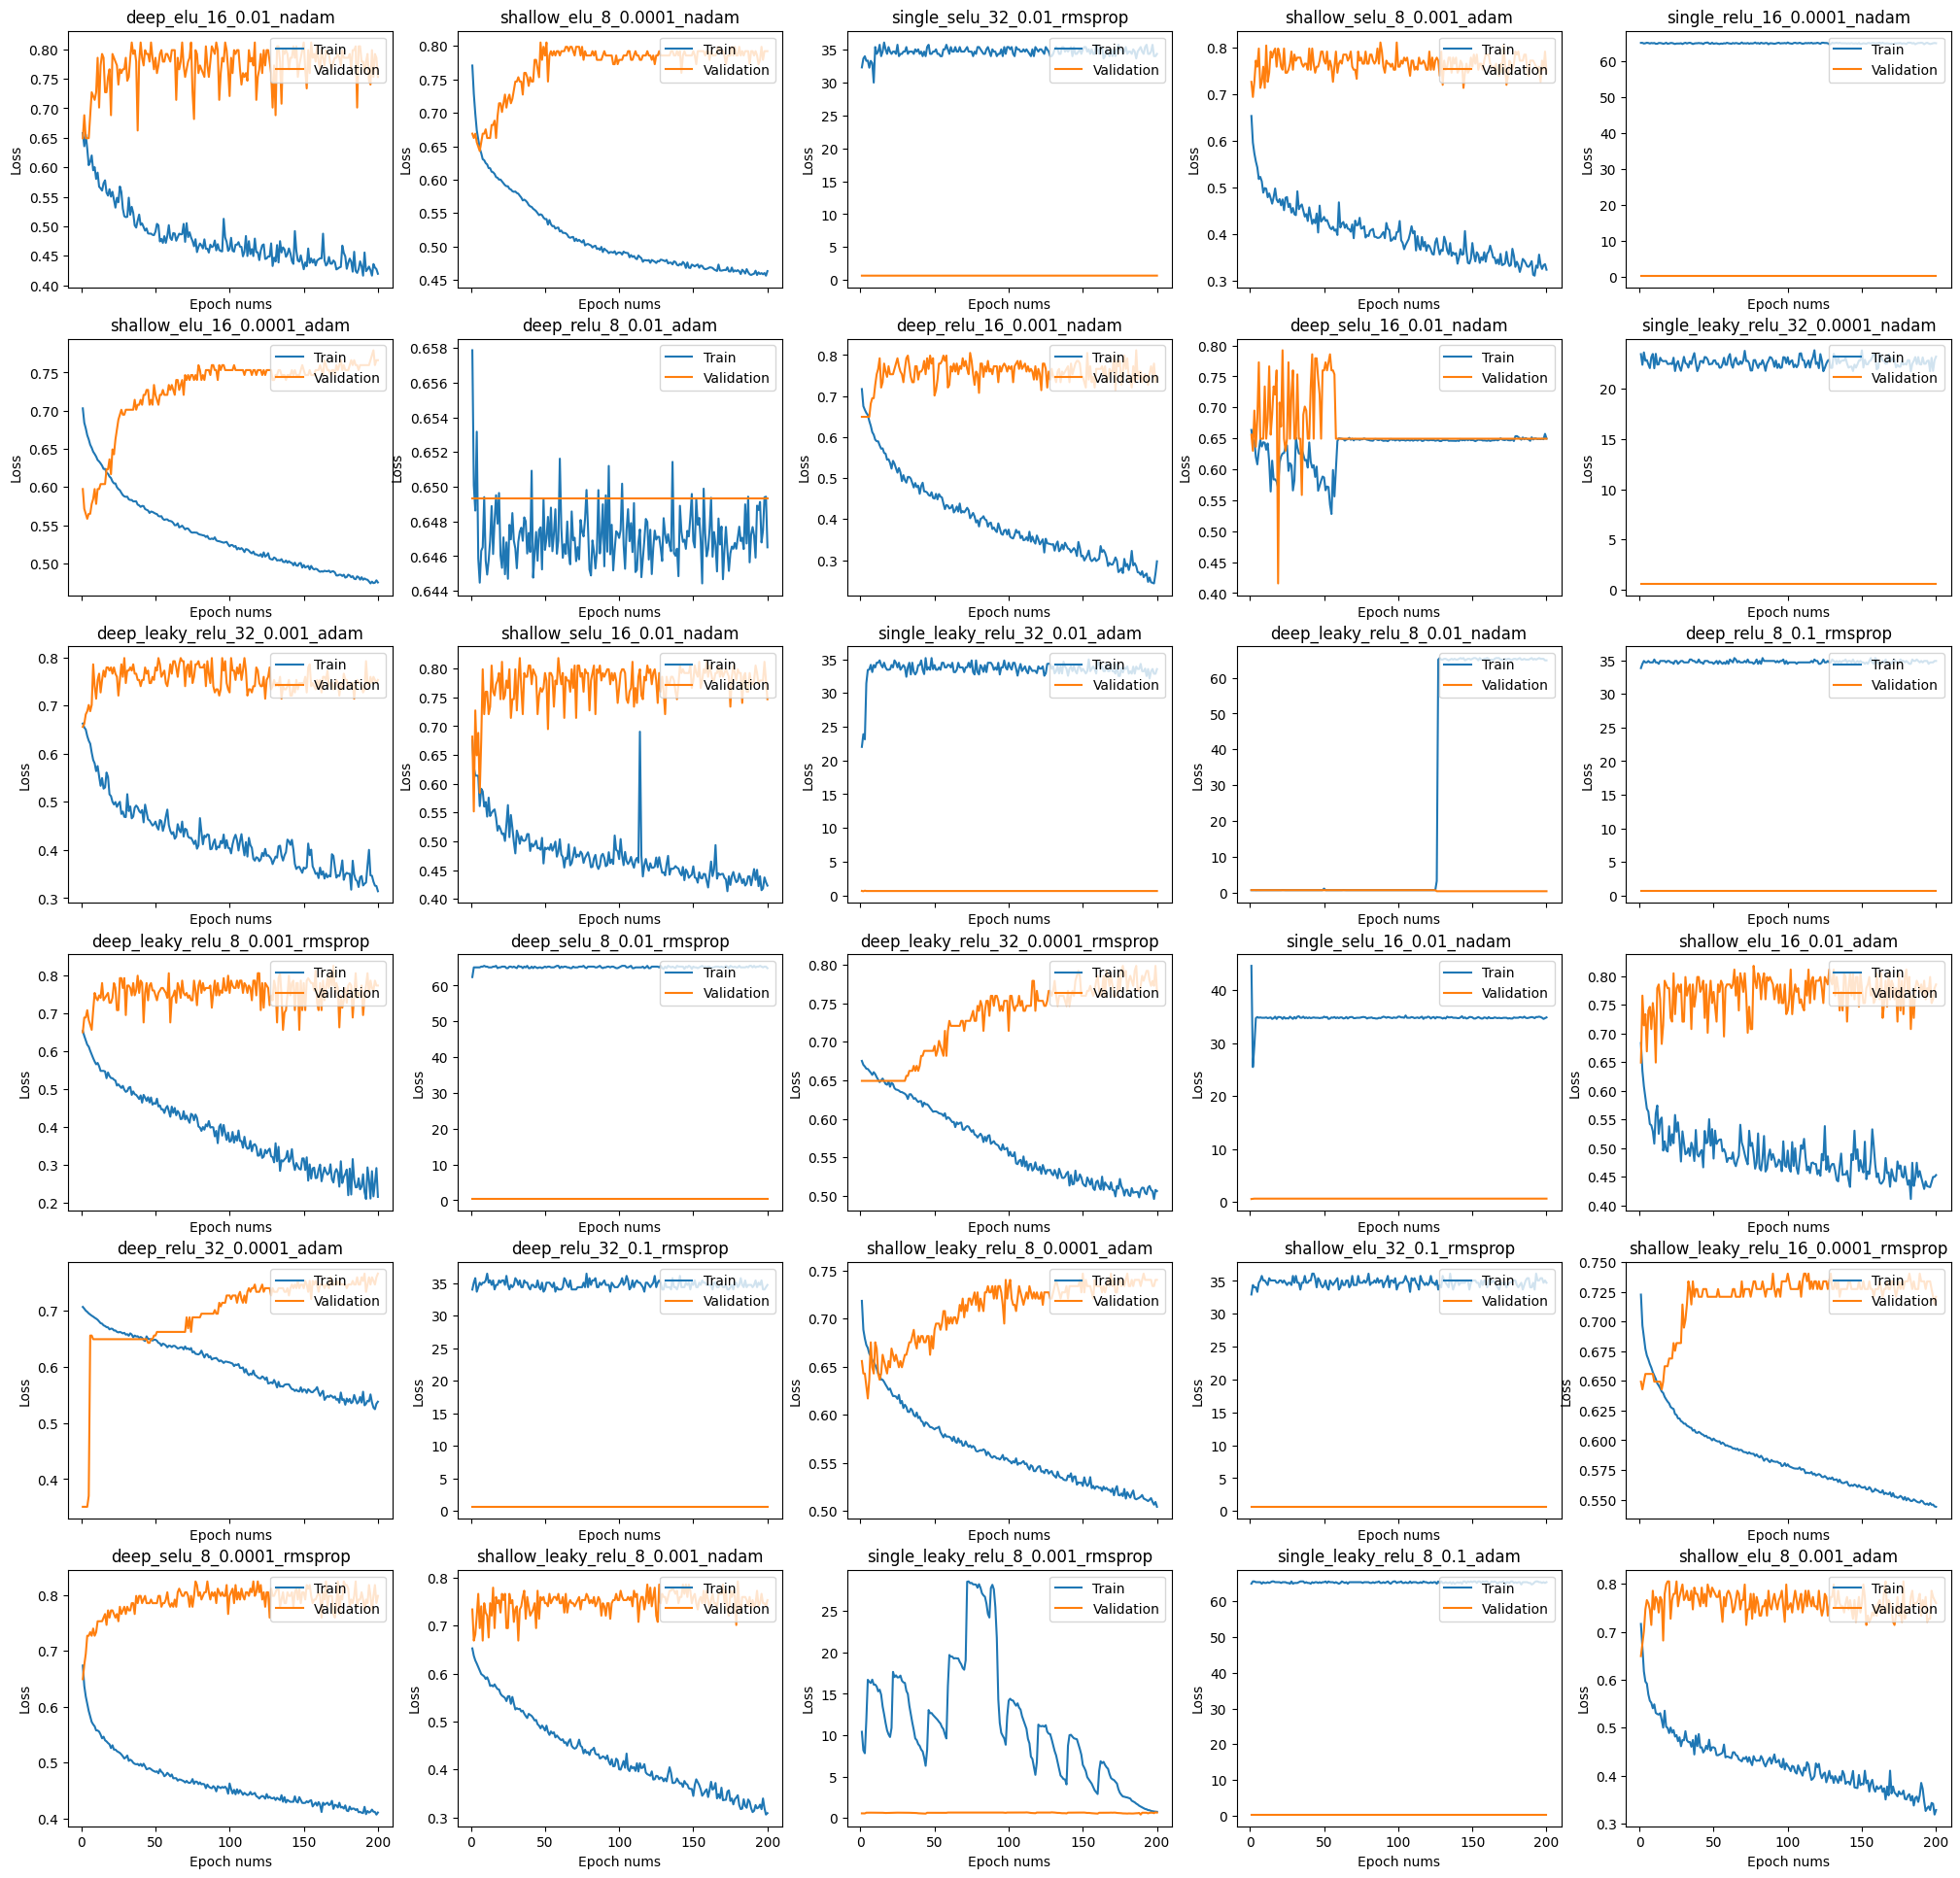

In [21]:
drawing_curves(first_results)

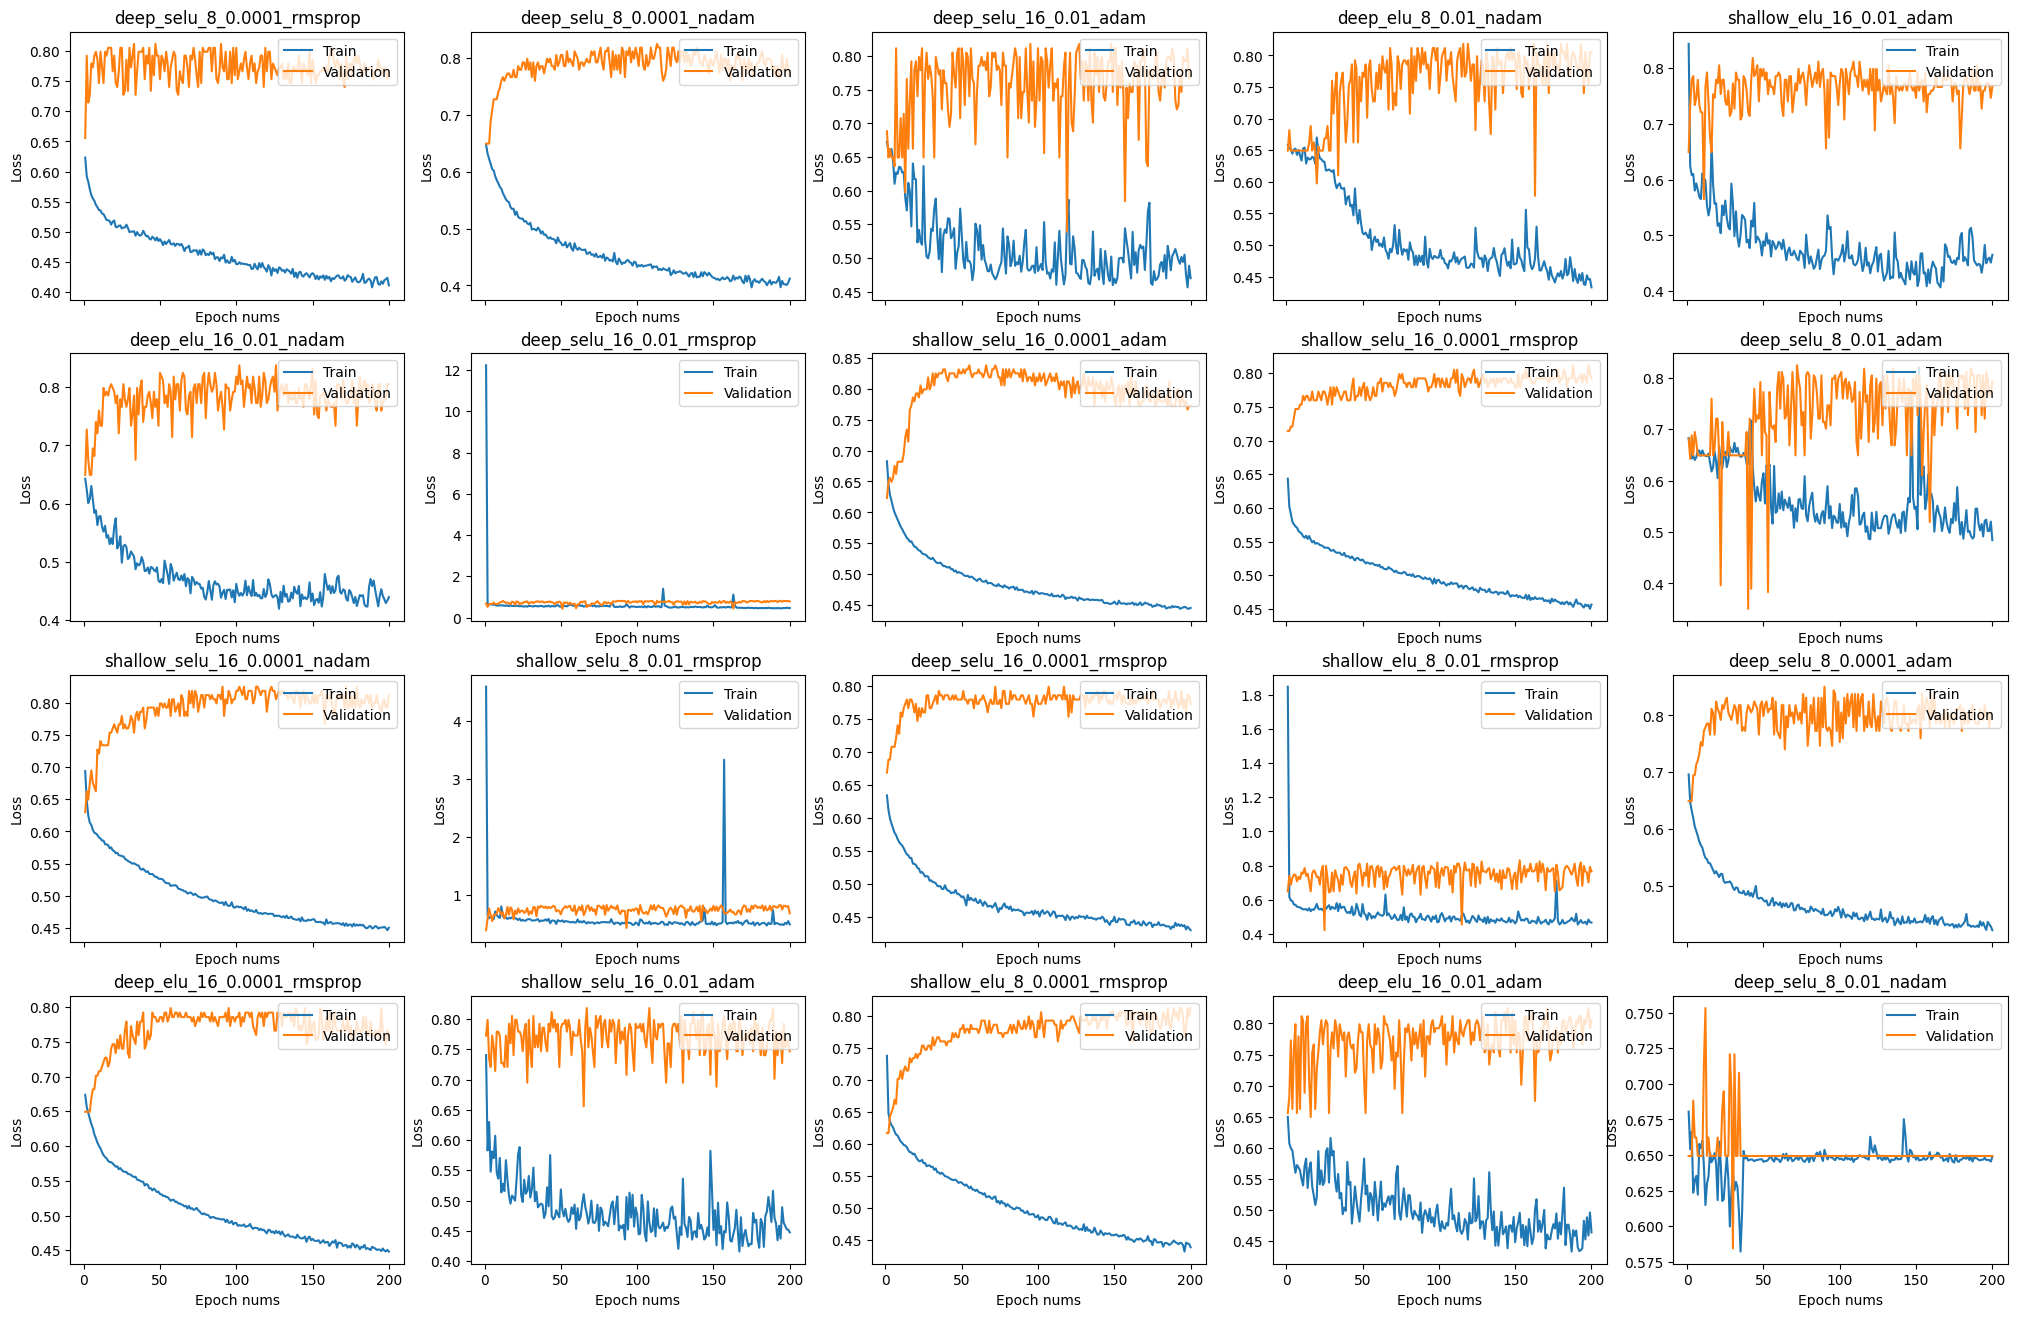

In [22]:
drawing_curves(second_results)

#### 3.2 boxplots

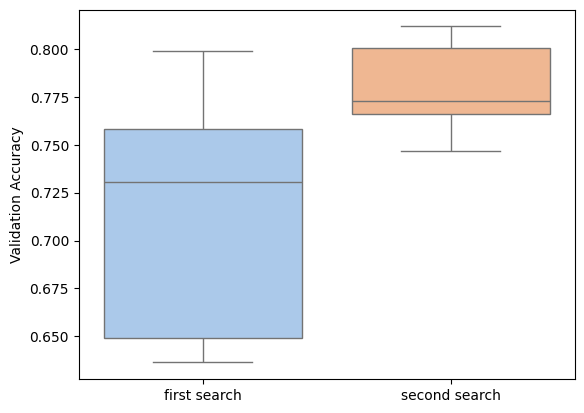

In [23]:
# boxplots to show
#
# Drawing the learning curves
#
first_result_df['tag'] = "first search"
second_result_df['tag'] = "second search"
all_result_df = pd.concat([first_result_df, second_result_df])


ax = sns.boxplot(data=all_result_df, x='tag', hue="tag", y="val_acc", 
                 orient='v', showfliers=False, palette=sns.color_palette('pastel', 2))
ax.set(xlabel=None, ylabel='Validation Accuracy')
pass


#### 3.3 Training Acc v.s. Validating Acc

In [24]:
def draw_accs(res_df, title=None):
    fig = plt.figure(figsize=(4, 4))
    # res_df['train_acc'] = res_df['trains_accs']
    res_df['train_acc'] = res_df['train_accs'].apply(lambda x: x[-1])
    res_df['model_version'] = res_df['trial_tag'].apply(lambda x: x.split('_')[0])
    plt.plot((0, 1), (0, 1), ls='--', c='k')
    sns.scatterplot(data=res_df, x='train_acc', y='val_acc', hue='model_version')
    if title is not None:
        plt.title(title)
    plt.xlabel('Training Accuracy')
    plt.ylabel('Validation Accuracy')
    pass

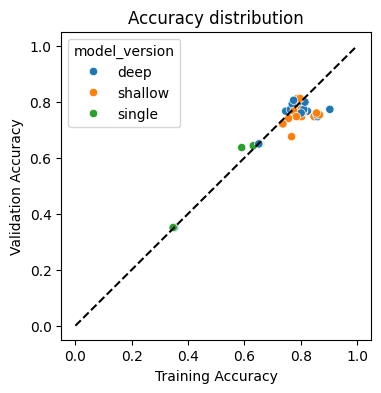

In [25]:
draw_accs(pd.concat([first_result_df, second_result_df]), 'Accuracy distribution')
# draw_accs(second_result_df, 'Accuracy distribution in second search')

#### 3.4 Confusion matrix

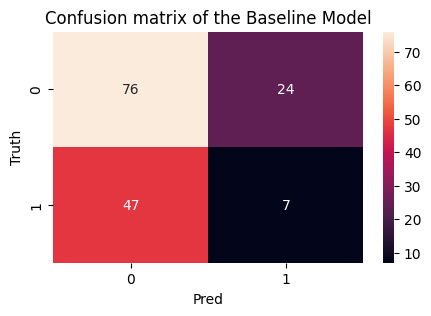

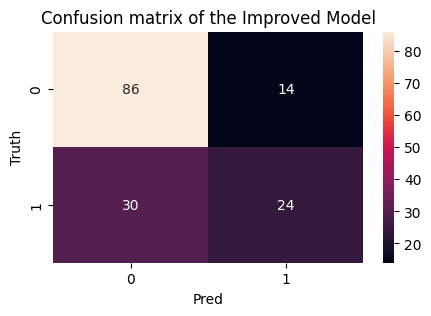

In [26]:
def draw_confusion(conf_mat, title=None):
    conf_mat = json.loads(conf_mat)
    plt.figure(figsize=(5, 3))
    if title is not None:
        plt.title(title)
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.xlabel('Pred')
    plt.ylabel('Truth')
    plt.show()

draw_confusion(baseline_res['confusion_matrix'], "Confusion matrix of the Baseline Model")
draw_confusion(best_param_res['confusion_matrix'], "Confusion matrix of the Improved Model")